In [232]:
import json
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchvision import models
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import os
import math
from sklearn import preprocessing

In [11]:
with h5py.File("data02/london_lite_gt.h5","r") as f:
    fovs = f["fov"][:]
    sim = f["sim"][:].astype(np.uint8)

In [12]:
def bag_of_words(centroids, img_descriptors):
    n_centroids = centroids.shape[0]  # number of centroids found with the KMeans clustering
    n_descriptors = img_descriptors.shape[0]  # number of descriptors extracted from the image

    bow_vector = np.zeros(n_centroids)

    for i in range(n_descriptors):
        idx = np.argmin(np.linalg.norm(centroids - img_descriptors[i], axis=1), axis=0)
        bow_vector[idx] += 1
    return bow_vector

In [119]:
def img_to_grid(img, n):
    assert math.log2(n).is_integer(), "n must be a power of 2"
    part_size = img.shape[1]/n

    parts = []
    for i in range(n):
        for j in range(n):
            x_start_idx = int(i*part_size)
            x_end_idx = int(i*part_size + part_size)

            y_start_idx = int(j*part_size)
            y_end_idx = int(j*part_size + part_size)

            part = img[:, y_start_idx:y_end_idx, x_start_idx:x_end_idx]
            parts.append(part)

    return torch.stack(parts)

In [99]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, json_path, transform=None, n=8):
        self.transform=transform
        self.n = n
        self.root_dir = root_dir
        with open(json_path,"r") as f:
            m_idx = json.load(f)
            self.m_imgs = np.array(m_idx["im_paths"])

    def __len__(self):
        return len(self.m_imgs)

    def __getitem__(self, idx):
        img = plt.imread(os.path.join(self.root_dir, self.m_imgs[idx]))

        if self.transform:
            img = self.transform(img)

        return img

In [257]:
# def create_deep_descriptors():
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Loaded device: {device}")

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model = model.to(device)

Loaded device: cuda


In [258]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256), antialias=False),
    # transforms.Normalize(mean=0.5, std=0.1)
])

n_patch = 16

database = CustomDataset(root_dir="data02", json_path="data02/database/database_lite.json", transform=transform)
# loader = DataLoader(database, batch_size=batch_size)

kmeans = MiniBatchKMeans(n_clusters=100, random_state=0, batch_size=n_patch**2)

# Find centroids
print("Finding centroids...")
for img in tqdm(database):
    patches = img_to_grid(img, n_patch)
    patches = patches.to(device)
    with torch.no_grad():
        output = model(patches)
        kmeans.partial_fit(output.cpu()[:, :, 0, 0])

centroids = kmeans.cluster_centers_

Finding centroids...


  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\koend\anaconda3\envs\FIR\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


In [262]:
centroids, centroids.shape

(array([[0.01451285, 0.09002747, 0.018005  , ..., 0.00767836, 0.00504793,
         0.00646481],
        [0.00620797, 0.00703138, 0.02261735, ..., 0.02402453, 0.00089276,
         0.00032571],
        [0.02473735, 0.04873321, 0.00551227, ..., 0.01359658, 0.00203635,
         0.        ],
        ...,
        [0.        , 0.00414484, 0.00367822, ..., 0.0021011 , 0.        ,
         0.        ],
        [0.01788906, 0.01502565, 0.01054014, ..., 0.01663597, 0.00164475,
         0.0057544 ],
        [0.0552277 , 0.0375053 , 0.01167264, ..., 0.00547053, 0.01627882,
         0.00460557]]),
 (100, 2048))

In [259]:
# Create BoVW vectors
print("Finding centroids...")
bow_map_images = None
for img in tqdm(database):
    patches = img_to_grid(img, n_patch)
    patches = patches.to(device)
    with torch.no_grad():
        output = model(patches)
        bow = bag_of_words(centroids, output.cpu().numpy()[:, :, 0, 0])
        if bow_map_images is None:
            bow_map_images = bow
        else:
            bow_map_images = np.vstack( (bow_map_images, bow))

Finding centroids...


  0%|          | 0/1000 [00:00<?, ?it/s]

In [216]:
bow_map_images.shape

(1000, 100)

In [264]:
orig_bow_map_images = bow_map_images

# Compute z-score statistics
scaler = preprocessing.StandardScaler().fit(bow_map_images)
# Normalize the vectors of the map collection (0 mean and 1 std)
bow_map_images = scaler.transform(bow_map_images)

In [218]:
np.std(bow_map_images)

1.0000000000000002

In [219]:
bow_map_images[0]

array([-1.25284298e+00, -1.75682956e+00, -8.92920419e-01, -8.06761864e-01,
        5.53245583e-02, -9.22878624e-01,  1.25517999e-01, -1.19231761e+00,
        1.73835091e+01, -6.93772467e-01,  1.41132408e+00, -9.51077475e-01,
       -1.25269228e+00,  1.59098090e+00, -6.61009297e-01,  9.41359370e-01,
        3.51867398e-01,  1.04725923e+00,  8.95975042e-01, -1.27497263e+00,
       -7.78696646e-01,  9.36309502e-01, -8.39247570e-01, -1.15045881e+00,
       -5.13443778e-01, -7.24347516e-01, -1.15382099e+00, -1.01312822e+00,
       -1.23952990e+00, -9.37047798e-02, -1.03242646e+00, -3.86180051e-01,
       -8.64762026e-01,  2.32637328e-01,  1.26098418e+00,  1.66870688e+00,
        7.61344104e-01,  5.31514076e-01, -5.71267718e-01, -1.40905006e+00,
        2.29054842e+00, -1.40081930e+00, -1.17168131e+00,  1.05104975e-02,
       -1.52555649e+00, -1.25057429e+00,  5.79115834e-02, -8.77008416e-01,
       -8.69974474e-01, -1.79412202e+00,  1.19653002e+00,  2.08754219e+00,
       -3.02918659e-01, -

In [265]:
def retrieve_images(map_bow_vectors, query_bow):
    # dists = np.linalg.norm(map_bow_vectors - query_bow, axis=1)
    #
    # idxs = np.argsort(np.linalg.norm(map_bow_vectors - query_bow, axis=1))
    # print(dists[idxs][:20])
    return np.argsort(np.linalg.norm(map_bow_vectors - query_bow, axis=1))

q_database = CustomDataset(root_dir="data02", json_path="data02/query/query_lite.json", transform=transform)
# q_loader = DataLoader(database, batch_size=1)

# query_idx = 100
for query_idx, q_image in enumerate(q_database):
    patches = img_to_grid(q_image, n_patch)
    patches = patches.to(device)
    with torch.no_grad():
        output = model(patches)
        bow = bag_of_words(centroids, output.cpu().numpy()[:, :, 0, 0])

    # Normalize the query BoW vector using the mean and variance of the map (computed earlier and saved into the scaler object)
    bow = scaler.transform(bow.reshape(-1, 1).transpose())
    bow = bow.transpose().reshape(-1)

    # # Retrieve the indices of the top-10 similar images from the map
    retrieved_images = retrieve_images(bow_map_images, bow)
    # print('Indices of similar images retrieved: ', retrieved_images[:50])
    # # Indices of the relevant map images for the query: we have the relevance judgements (Ground truth)
    relevant_images = np.where(sim[query_idx, :] == 1)[0]
    # print('Indices of relevant images (given in the GT relevance judgements): ', relevant_images)
    print(f"{query_idx}: {len(set(retrieved_images[:50]).intersection(set(relevant_images)))} / {len(relevant_images)}")
    print()
    # if len(set(retrieved_images).intersection(set(relevant_images))) != len(relevant_images):
    #     print(f"{query_idx}: {len(set(retrieved_images).intersection(set(relevant_images)))} / {len(relevant_images)}")

0: 0 / 1

1: 0 / 2

2: 0 / 2

3: 0 / 3

4: 0 / 3

5: 0 / 3

6: 1 / 5

7: 0 / 6

8: 0 / 7

9: 0 / 8

10: 1 / 9

11: 1 / 10

12: 1 / 11

13: 1 / 13

14: 5 / 14

15: 1 / 16

16: 1 / 17

17: 1 / 17

18: 1 / 17

19: 1 / 17

20: 1 / 17

21: 0 / 17

22: 0 / 17

23: 0 / 17

24: 0 / 17

25: 1 / 17

26: 2 / 17

27: 0 / 17

28: 0 / 17

29: 0 / 16

30: 1 / 15

31: 1 / 5

32: 0 / 5

33: 0 / 6

34: 1 / 6

35: 1 / 6

36: 1 / 6

37: 1 / 6

38: 0 / 6

39: 1 / 6

40: 0 / 6

41: 0 / 2

42: 0 / 2

43: 0 / 4

44: 0 / 3

45: 1 / 3

46: 1 / 3

47: 1 / 2

48: 0 / 2

49: 0 / 2

50: 0 / 11

51: 1 / 12

52: 0 / 13

53: 1 / 13

54: 0 / 13

55: 0 / 30

56: 3 / 30

57: 3 / 30

58: 3 / 30

59: 3 / 30

60: 2 / 30

61: 2 / 27

62: 0 / 5

63: 1 / 5

64: 0 / 3

65: 0 / 2

66: 0 / 3

67: 0 / 4

68: 1 / 7

69: 1 / 6

70: 1 / 5

71: 0 / 4

72: 0 / 3



KeyboardInterrupt: 

In [230]:
bow_map_images.shape

(1000, 100)

In [236]:
pca = PCA(n_components=2)
decomposed = pca.fit_transform(bow_map_images)

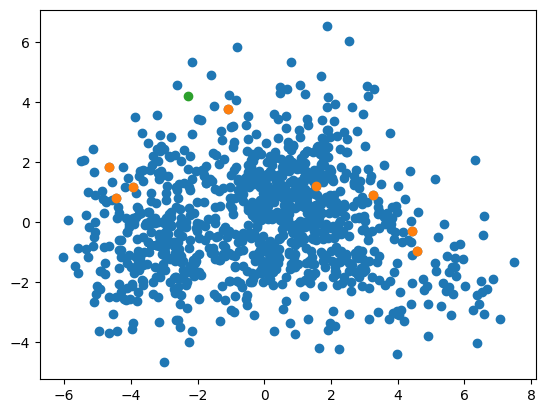

In [245]:
q_idx = 150

# query_idx = 100
patches = img_to_grid(q_database[q_idx], n_patch)
patches = patches.to(device)
output = model(patches)
bow = bag_of_words(centroids, output.detach().cpu().numpy()[:, :, 0, 0])
bow = scaler.transform(bow.reshape(-1, 1).transpose())
bow = bow.transpose().reshape(-1)
bow = pca.transform(bow[None, :])

rel = np.where(sim[q_idx, :] == 1)

plt.scatter(decomposed[:, 0], decomposed[:, 1])
plt.scatter(decomposed[rel, 0], decomposed[rel, 1])
plt.scatter(bow[0, 0], bow[0, 1])